# Check cleaned eeg data 

In [12]:
!pip install PyQt5

   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/6.8 MB 648.1 kB/s eta 0:00:11
   - -------------------------------------- 0.3/6.8 MB 2.1 MB/s eta 0:00:04
   --- ------------------------------------ 0.6/6.8 MB 3.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.0/6.8 MB 4.7 MB/s eta 0:00:02
   -------- ------------------------------- 1.5/6.8 MB 5.5 MB/s eta 0:00:01
   ----------- ---------------------------- 2.0/6.8 MB 6.2 MB/s eta 0:00:01
   -------------- ------------------------- 2.5/6.8 MB 6.9 MB/s eta 0:00:01
   ------------------ --------------------- 3.1/6.8 MB 7.6 MB/s eta 0:00:01
   ---------------------- ----------------- 3.8/6.8 MB 8.3 MB/s eta 0:00:01
   -------------------------- ------------- 4.5/6.8 MB 9.0 MB/s eta 0:00:01
   ------------------------------ --------- 5.3/6.8 MB 9.6 MB/s eta 0:00:01
   ---------------------

In [66]:
import itertools
import PyQt5
import numpy as np
import os
import pyxdf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import mne
import json
import glob
import re
from scipy import signal
import importlib
import multiprocessing as mp
import sys
# from utils.read_data import *

#from mne.preprocessing import ASR


In [67]:
mne.sys_info()

Platform             Windows-10-10.0.19045-SP0
Python               3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]
Executable           C:\Users\akeshava\.conda\envs\gti_mne\python.exe
CPU                  Intel64 Family 6 Model 85 Stepping 4, GenuineIntel (16 cores)
Memory               31.7 GB

Core
├☑ mne               1.6.1 (latest release)
├☑ numpy             1.26.4 (unknown linalg bindings (threadpoolctl module not found: No module named 'threadpoolctl'))
├☑ scipy             1.12.0
├☑ matplotlib        3.8.3 (backend=module://matplotlib_inline.backend_inline)
├☑ pooch             1.8.1
└☑ jinja2            3.1.3

Numerical (optional)
├☑ pandas            2.2.1
└☐ unavailable       sklearn, numba, nibabel, nilearn, dipy, openmeeg, cupy

Visualization (optional)
├☑ qtpy              2.4.1 (PyQt5=5.15.2)
├☑ ipywidgets        8.1.2
└☐ unavailable       pyvista, pyvistaqt, vtk, ipympl, pyqtgraph, mne-qt-browser, trame_client, trame_serve

In [68]:
DATA_PATH = './raw_data/'
PROCESSED_PATH = './processed_data/'

montagefile = "./ANT_EEG_channel_mapping.json"

os.makedirs(PROCESSED_PATH,  exist_ok=True)

In [90]:
trial_info = pd.read_csv(f'{PROCESSED_PATH}/trial_conditions.csv')

trial_info['raw_data_file'] = (
    DATA_PATH 
    + trial_info['subject_id'].astype(str) + '/' 
    + trial_info['subject_id'].astype(str) + '_' 
    + trial_info['block_id'].astype(str)
    + '.xdf'
)



def find_preprocessed_files(subject_id='', block_id='', save_dir=''):
#     D:\projects\GTI_decoding\code\paper\processed_data\M009\4\eeg\04_cleaned\block_4_eeg.fif
    clean_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/04_cleaned/*_eeg.fif"))
    epoched_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/03_epoched/*_epo.fif"))
    raw_epo_fname = glob.glob(os.path.join(save_dir,subject_id, str(block_id),"eeg/05_rawepochs/*_epo.fif"))
    
    if len(clean_fname)==0 or len(epoched_fname) == 0 or len(raw_epo_fname) == 0:
        return ['', '', '']
    
    return [clean_fname[0], epoched_fname[0], raw_epo_fname[0]]

for idx, row in trial_info.iterrows():
    trial_info.loc[idx, ['cleaned_data', 'epoched_data', 'raw_epochs']] = (
        find_preprocessed_files
        (row['subject_id'], 
         row['block_id'], 
         './processed_data/'
        )
    )
    
trial_info = trial_info.query('epoched_data !=""')

trial_info.trial_id = trial_info.trial_id - 1
trial_info.trial_id = trial_info.groupby('subject_id').trial_id.cumcount()

trial_info.shape

(6672, 14)

In [91]:
trial_info.head()

Unnamed: 0 subject_id  block_id  trial_id familiarity  task orientation  \
0           0       M006         1         0       unfam   use       right   
1           1       M006         1         1         fam   use       right   
2           2       M006         1         2         fam   use       right   
3           3       M006         1         3         fam  lift       right   
4           4       M006         1         4       unfam   use        left   

    tool_name  time        condition               raw_data_file  \
0  fishscaler   732  unfam/use/right  ./raw_data/M006/M006_1.xdf   
1  paintbrush   732    fam/use/right  ./raw_data/M006/M006_1.xdf   
2        fork   732    fam/use/right  ./raw_data/M006/M006_1.xdf   
3     spatula   732   fam/lift/right  ./raw_data/M006/M006_1.xdf   
4  fishscaler   732   unfam/use/left  ./raw_data/M006/M006_1.xdf   

                                        cleaned_data  \
0  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
1  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
2  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
3  ./processed_data/M006\1\eeg/04_cleaned\block_1...   
4  ./processed_data/M006\1\eeg/04_cleaned\block_1...   

                                        epoched_data  \
0  ./processed_data/M006\1\eeg/03_epoched\block_1...   
1  ./processed_data/M006\1\eeg/03_epoched\block_1...   
2  ./processed_data/M006\1\eeg/03_epoched\block_1...   
3  ./processed_data/M006\1\eeg/03_epoched\block_1...   
4  ./processed_data/M006\1\eeg/03_epoched\block_1...   

                                          raw_epochs  
0  ./processed_data/M006\1\eeg/05_rawepochs\block...  
1  ./processed_data/M006\1\eeg/05_rawepochs\block...  
2  ./processed_data/M006\1\eeg/05_rawepochs\block...  
3  ./processed_data/M006\1\eeg/05_rawepochs\block...  
4  ./processed_data/M006\1\eeg/05_rawepochs\block...

In [94]:
trial_info.query('subject_id=="M020"')

Unnamed: 0 subject_id  block_id  trial_id familiarity  task orientation  \
3936        3936       M020         1         0         fam   use       right   
3937        3937       M020         1         1       unfam  lift        left   
3938        3938       M020         1         2         fam   use        left   
3939        3939       M020         1         3       unfam  lift        left   
3940        3940       M020         1         4       unfam  lift       right   
...          ...        ...       ...       ...         ...   ...         ...   
4219        4219       M020         6       283       unfam   use       right   
4220        4220       M020         6       284         fam  lift       right   
4221        4221       M020         6       285         fam   use        left   
4222        4222       M020         6       286       unfam   use       right   
4223        4223       M020         6       287       unfam   use        left   

         tool_name  time         condition               raw_data_file  \
3936          fork   732     fam/use/right  ./raw_data/M020/M020_1.xdf   
3937    fishscaler   732   unfam/lift/left  ./raw_data/M020/M020_1.xdf   
3938        wrench   732      fam/use/left  ./raw_data/M020/M020_1.xdf   
3939  flowercutter   732   unfam/lift/left  ./raw_data/M020/M020_1.xdf   
3940  flowercutter   732  unfam/lift/right  ./raw_data/M020/M020_1.xdf   
...            ...   ...               ...                         ...   
4219    fishscaler   732   unfam/use/right  ./raw_data/M020/M020_6.xdf   
4220       spatula   732    fam/lift/right  ./raw_data/M020/M020_6.xdf   
4221          fork   732      fam/use/left  ./raw_data/M020/M020_6.xdf   
4222  daisygrubber   732   unfam/use/right  ./raw_data/M020/M020_6.xdf   
4223  daisygrubber   732    unfam/use/left  ./raw_data/M020/M020_6.xdf   

                                           cleaned_data  \
3936  ./processed_data/M020\1\eeg/04_cleaned\block_1...   
3937  ./processed_data/M020\1\eeg/04_cleaned\block_1...   
3938  ./processed_data/M020\1\eeg/04_cleaned\block_1...   
3939  ./processed_data/M020\1\eeg/04_cleaned\block_1...   
3940  ./processed_data/M020\1\eeg/04_cleaned\block_1...   
...                                                 ...   
4219  ./processed_data/M020\6\eeg/04_cleaned\block_6...   
4220  ./processed_data/M020\6\eeg/04_cleaned\block_6...   
4221  ./processed_data/M020\6\eeg/04_cleaned\block_6...   
4222  ./processed_data/M020\6\eeg/04_cleaned\block_6...   
4223  ./processed_data/M020\6\eeg/04_cleaned\block_6...   

                                           epoched_data  \
3936  ./processed_data/M020\1\eeg/03_epoched\block_1...   
3937  ./processed_data/M020\1\eeg/03_epoched\block_1...   
3938  ./processed_data/M020\1\eeg/03_epoched\block_1...   
3939  ./processed_data/M020\1\eeg/03_epoched\block_1...   
3940  ./processed_data/M020\1\eeg/03_epoched\block_1...   
...                                                 ...   
4219  ./processed_data/M020\6\eeg/03_epoched\block_6...   
4220  ./processed_data/M020\6\eeg/03_epoched\block_6...   
4221  ./processed_data/M020\6\eeg/03_epoched\block_6...   
4222  ./processed_data/M020\6\eeg/03_epoched\block_6...   
4223  ./processed_data/M020\6\eeg/03_epoched\block_6...   

                                             raw_epochs  
3936  ./processed_data/M020\1\eeg/05_rawepochs\block...  
3937  ./processed_data/M020\1\eeg/05_rawepochs\block...  
3938  ./processed_data/M020\1\eeg/05_rawepochs\block...  
3939  ./processed_data/M020\1\eeg/05_rawepochs\block...  
3940  ./processed_data/M020\1\eeg/05_rawepochs\block...  
...                                                 ...  
4219  ./processed_data/M020\6\eeg/05_rawepochs\block...  
4220  ./processed_data/M020\6\eeg/05_rawepochs\block...  
4221  ./processed_data/M020\6\eeg/05_rawepochs\block...  
4222  ./processed_data/M020\6\eeg/05_rawepochs\block...  
4223  ./processed_data/M020\6\eeg/05_rawepochs\block...  

[288 rows x 14 columns]

In [71]:
epochs_list=[]
for ep in trial_info.query('subject_id == "M010"').epoched_data.unique():
    print(f"*********{ep}***********")
    epochs_list.append(mne.read_epochs(ep, verbose=False))
clean_epochs = mne.concatenate_epochs(epochs_list)

*********./processed_data/M010\1\eeg/03_epoched\block_1_epo.fif***********
*********./processed_data/M010\2\eeg/03_epoched\block_2_epo.fif***********
*********./processed_data/M010\3\eeg/03_epoched\block_3_epo.fif***********
*********./processed_data/M010\4\eeg/03_epoched\block_4_epo.fif***********
*********./processed_data/M010\5\eeg/03_epoched\block_5_epo.fif***********
*********./processed_data/M010\6\eeg/03_epoched\block_6_epo.fif***********
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)


In [84]:
clean_epochs.get_data().shape

C:\Users\akeshava\AppData\Local\Temp\ipykernel_6744\2447023153.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  clean_epochs.get_data().shape


(288, 64, 821)

In [72]:
clean_epochs.detrend=0

In [73]:
epochs_list=[]
for ep in trial_info.query('subject_id == "M010"').raw_epochs.unique():
    print(f"*********{ep}***********")
    epochs_list.append(mne.read_epochs(ep, verbose=False))
unclean_epochs = mne.concatenate_epochs(epochs_list)

*********./processed_data/M010\1\eeg/05_rawepochs\block_1_epo.fif***********
*********./processed_data/M010\2\eeg/05_rawepochs\block_2_epo.fif***********
*********./processed_data/M010\3\eeg/05_rawepochs\block_3_epo.fif***********
*********./processed_data/M010\4\eeg/05_rawepochs\block_4_epo.fif***********
*********./processed_data/M010\5\eeg/05_rawepochs\block_5_epo.fif***********
*********./processed_data/M010\6\eeg/05_rawepochs\block_6_epo.fif***********
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)


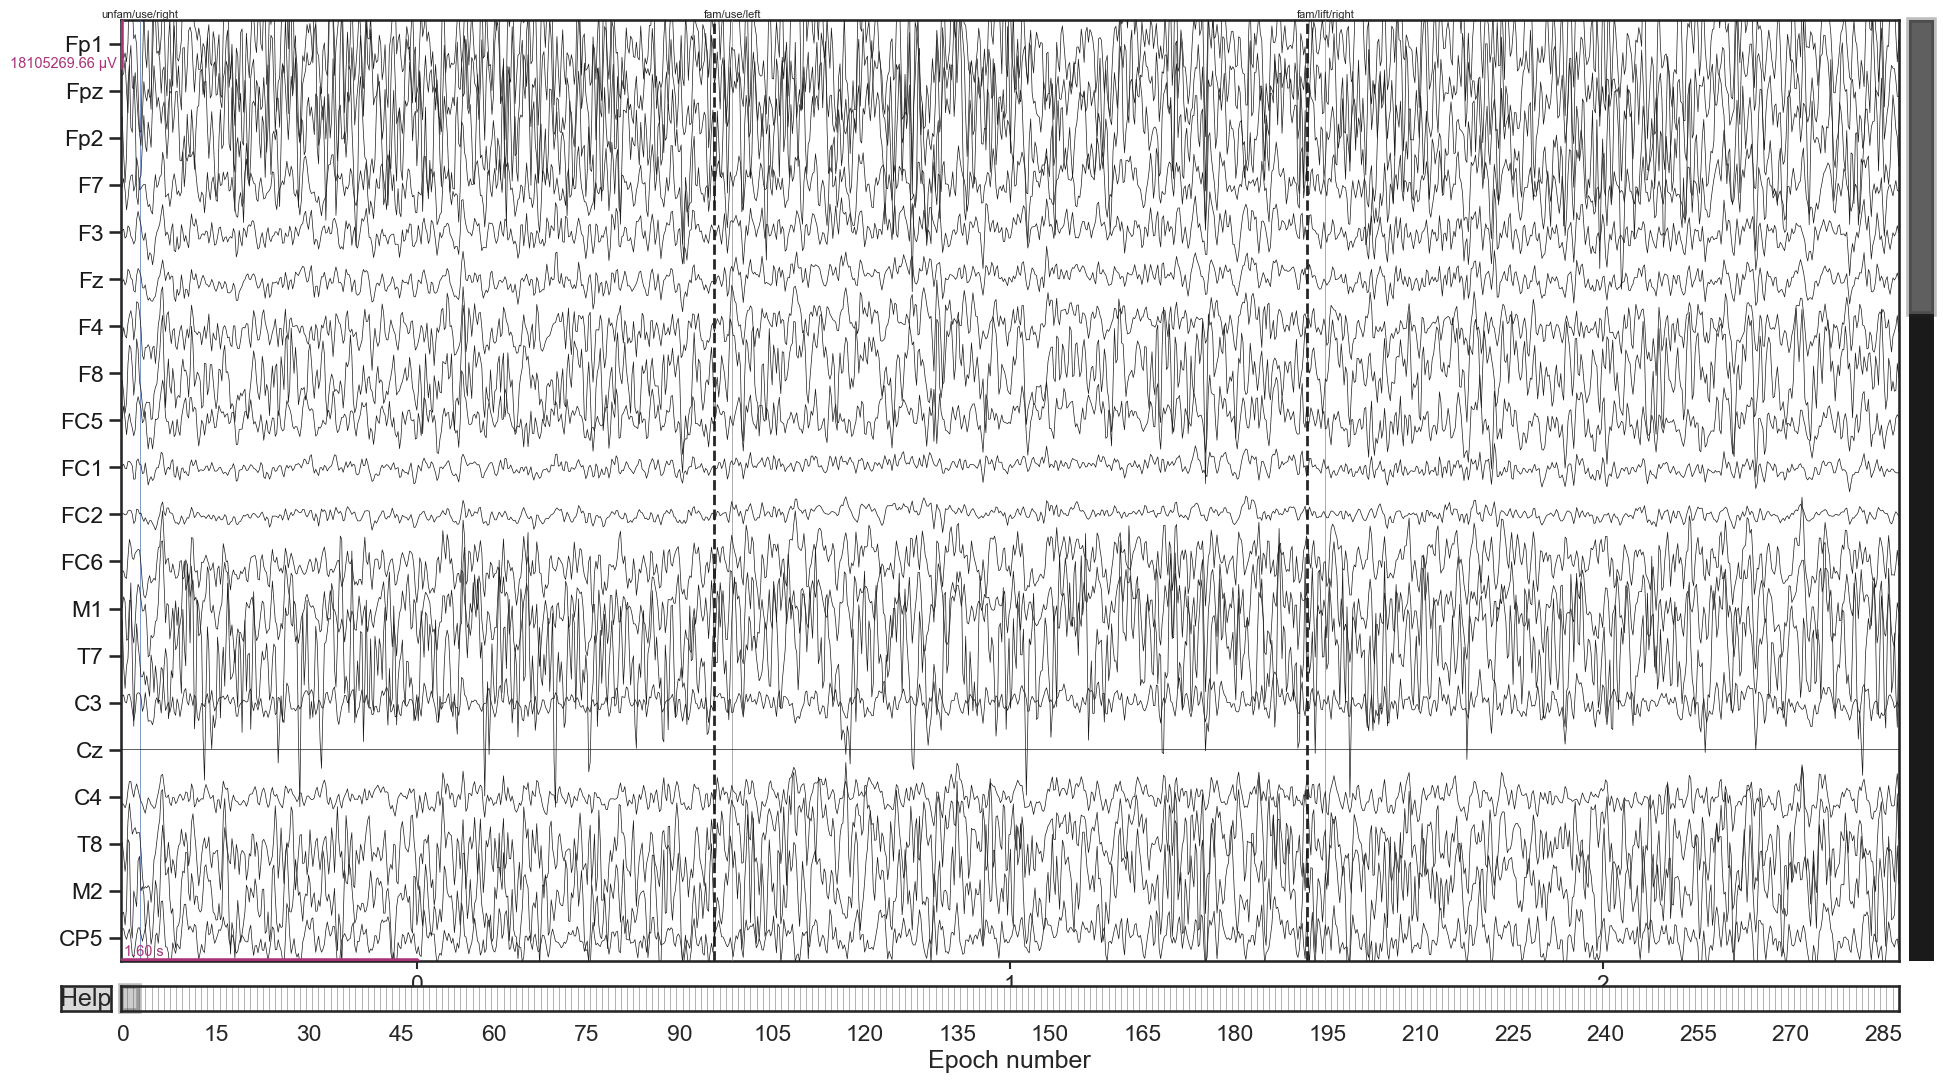

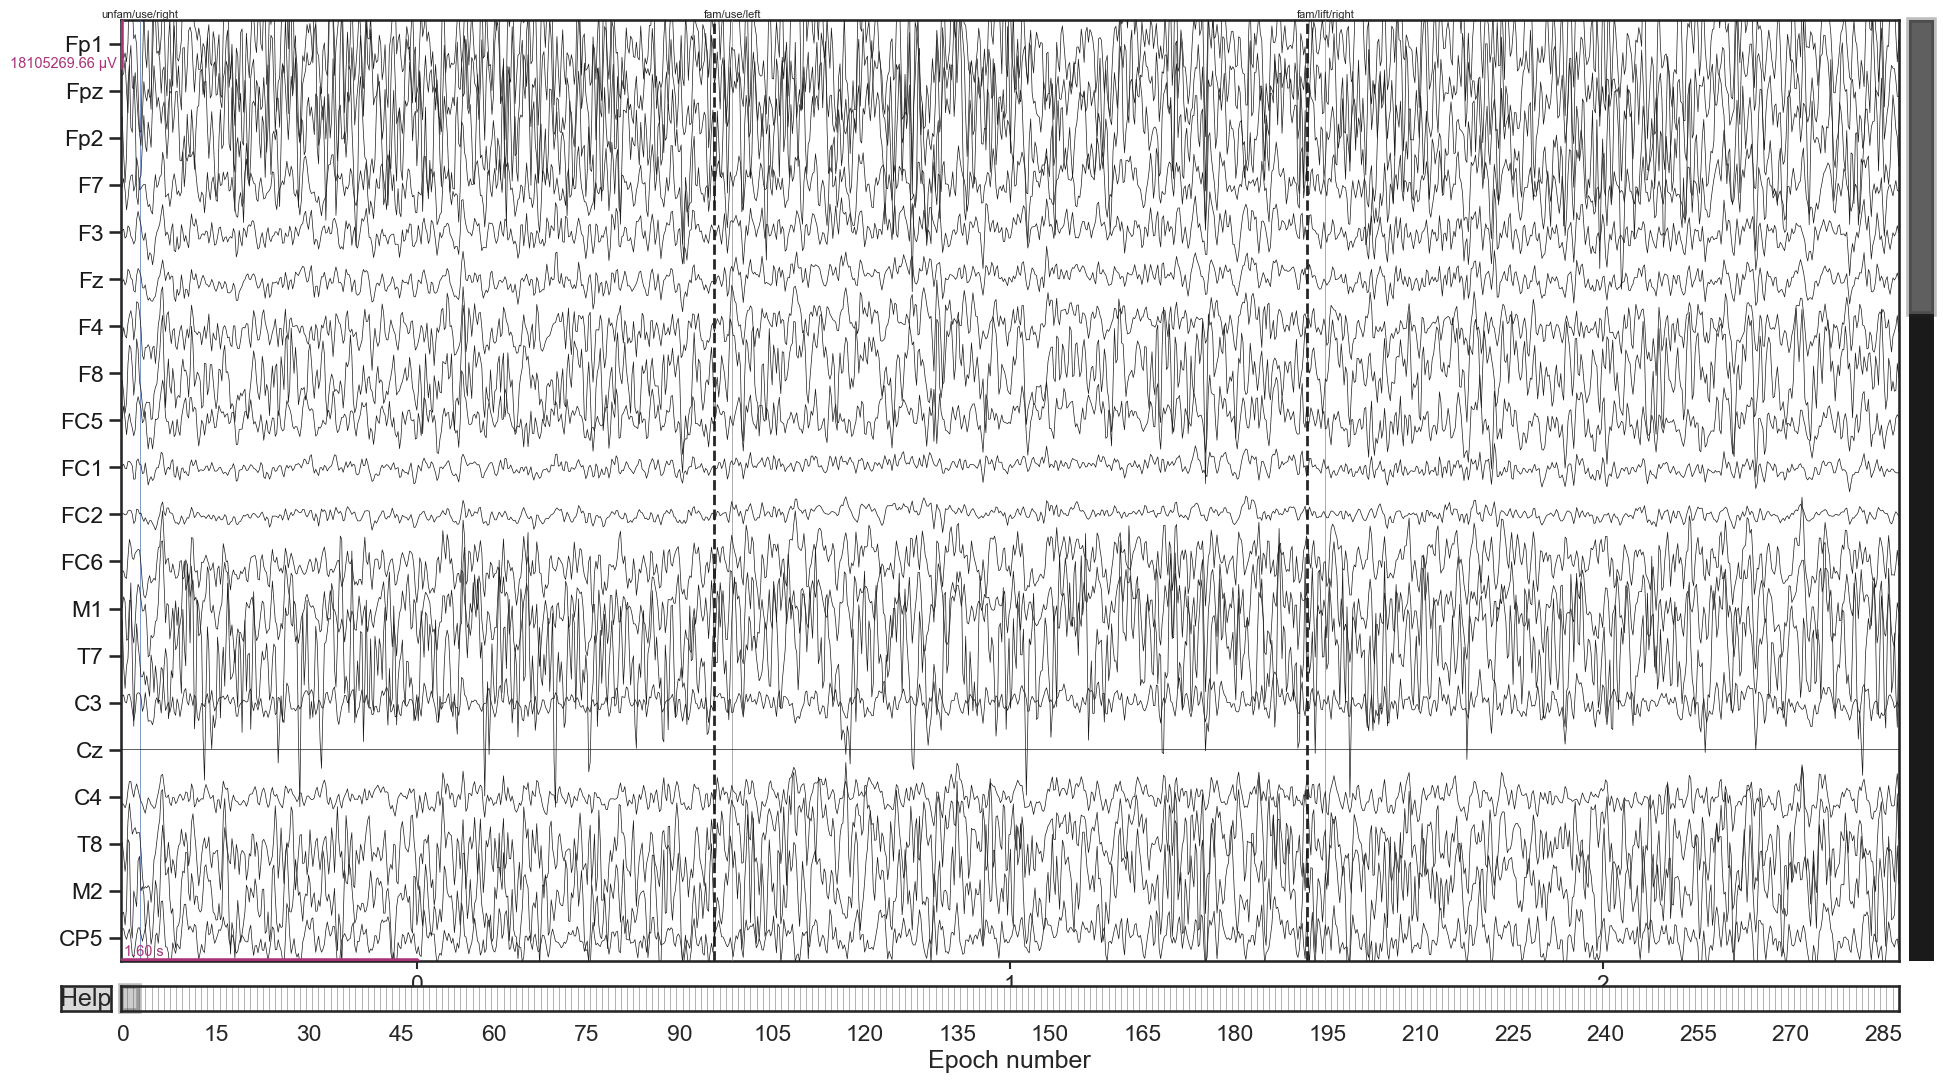

In [76]:
# % matplotlib qt5
clean_epochs.plot(n_epochs=3,
            scalings='auto',
            events=clean_epochs.events,
            event_id=clean_epochs.event_id,)


In [18]:
unclean_epochs.plot(n_epochs=3,
            scalings='auto',
            events=unclean_epochs.events,
            event_id=unclean_epochs.event_id,);

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\akeshava\.conda\envs\gti_mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


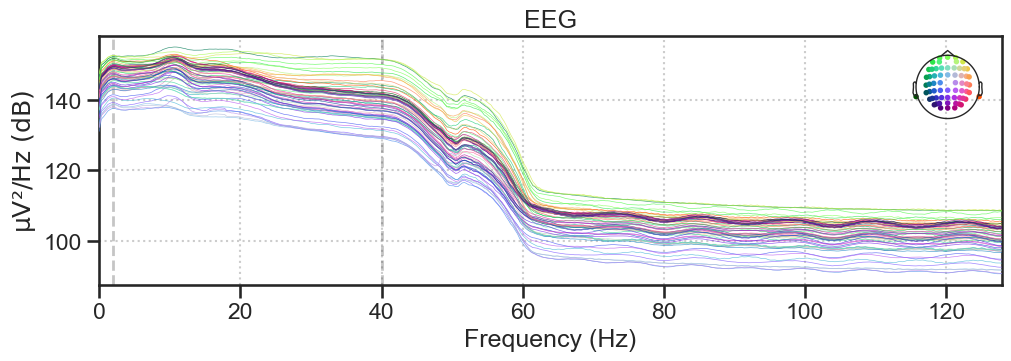

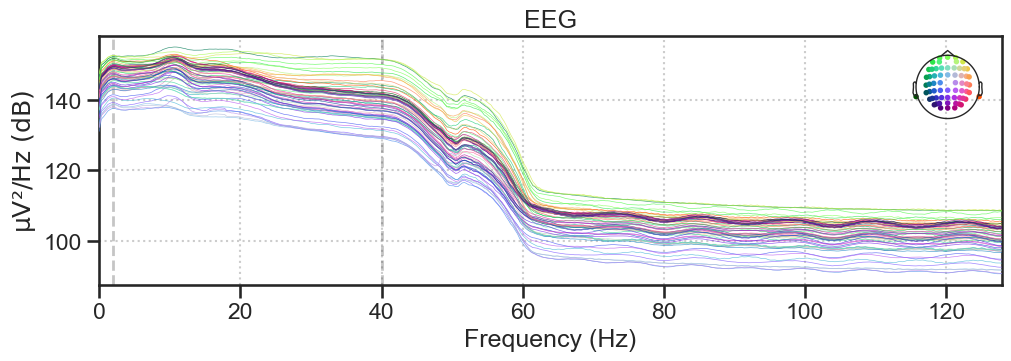

In [77]:
# _, ax=plt.subplots(figsize=(10, 6))

clean_epochs.compute_psd(remove_dc=True, exclude=['Cz']).plot(picks='data')

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\akeshava\.conda\envs\gti_mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


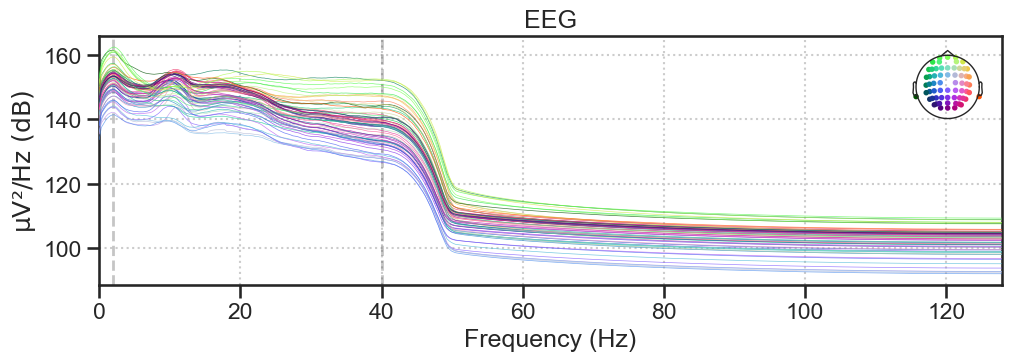

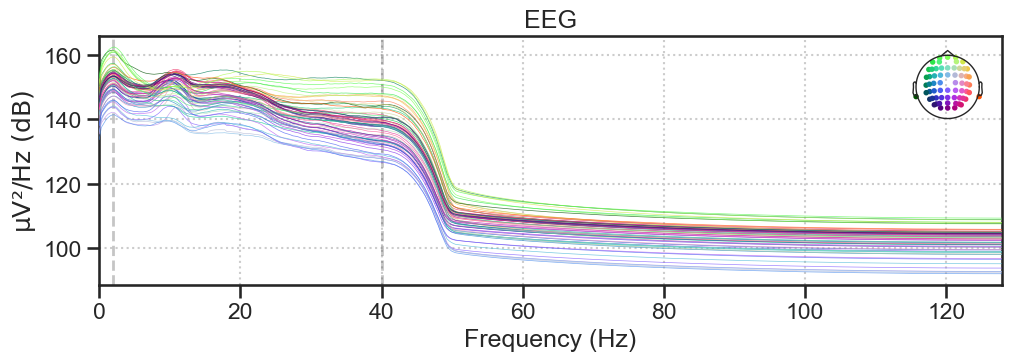

In [78]:
unclean_epochs.compute_psd(remove_dc=True, exclude=['Cz']).plot(picks='data')

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


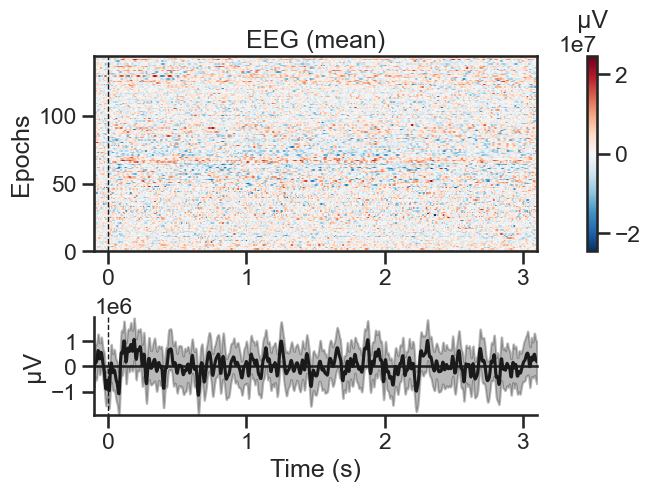

[<Figure size 640x480 with 3 Axes>]

In [79]:
%matplotlib inline

clean_epochs["lift"].plot_image(combine="mean", show=True)
# plt.show()

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


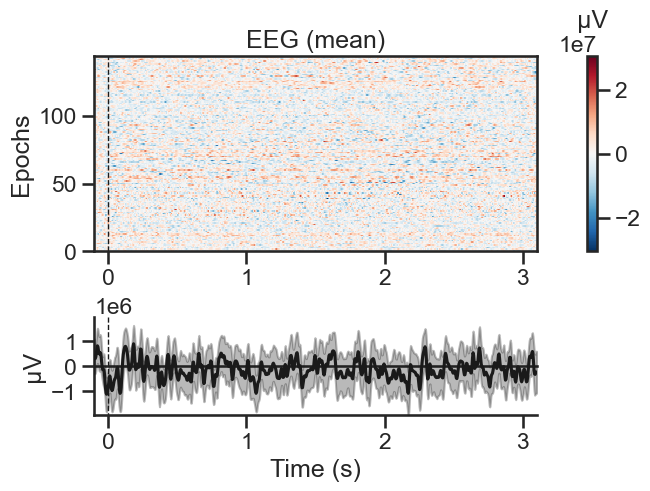

[<Figure size 640x480 with 3 Axes>]

In [80]:
%matplotlib inline

clean_epochs["use"].plot_image(combine="mean", show=True)
# plt.show()

In [81]:
clean_epochs.apply_baseline((-0.1, 0))

Applying baseline correction (mode: mean)


<EpochsArray |  288 events (all good), -0.101562 – 3.10156 s, baseline -0.1 – 0 s, ~115.5 MB, data loaded,
 'unfam/use/right': 36
 'fam/use/right': 36
 'fam/lift/right': 36
 'unfam/use/left': 36
 'fam/lift/left': 36
 'unfam/lift/left': 36
 'unfam/lift/right': 36
 'fam/use/left': 36>

C:\Users\akeshava\AppData\Local\Temp\ipykernel_6744\2024900321.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


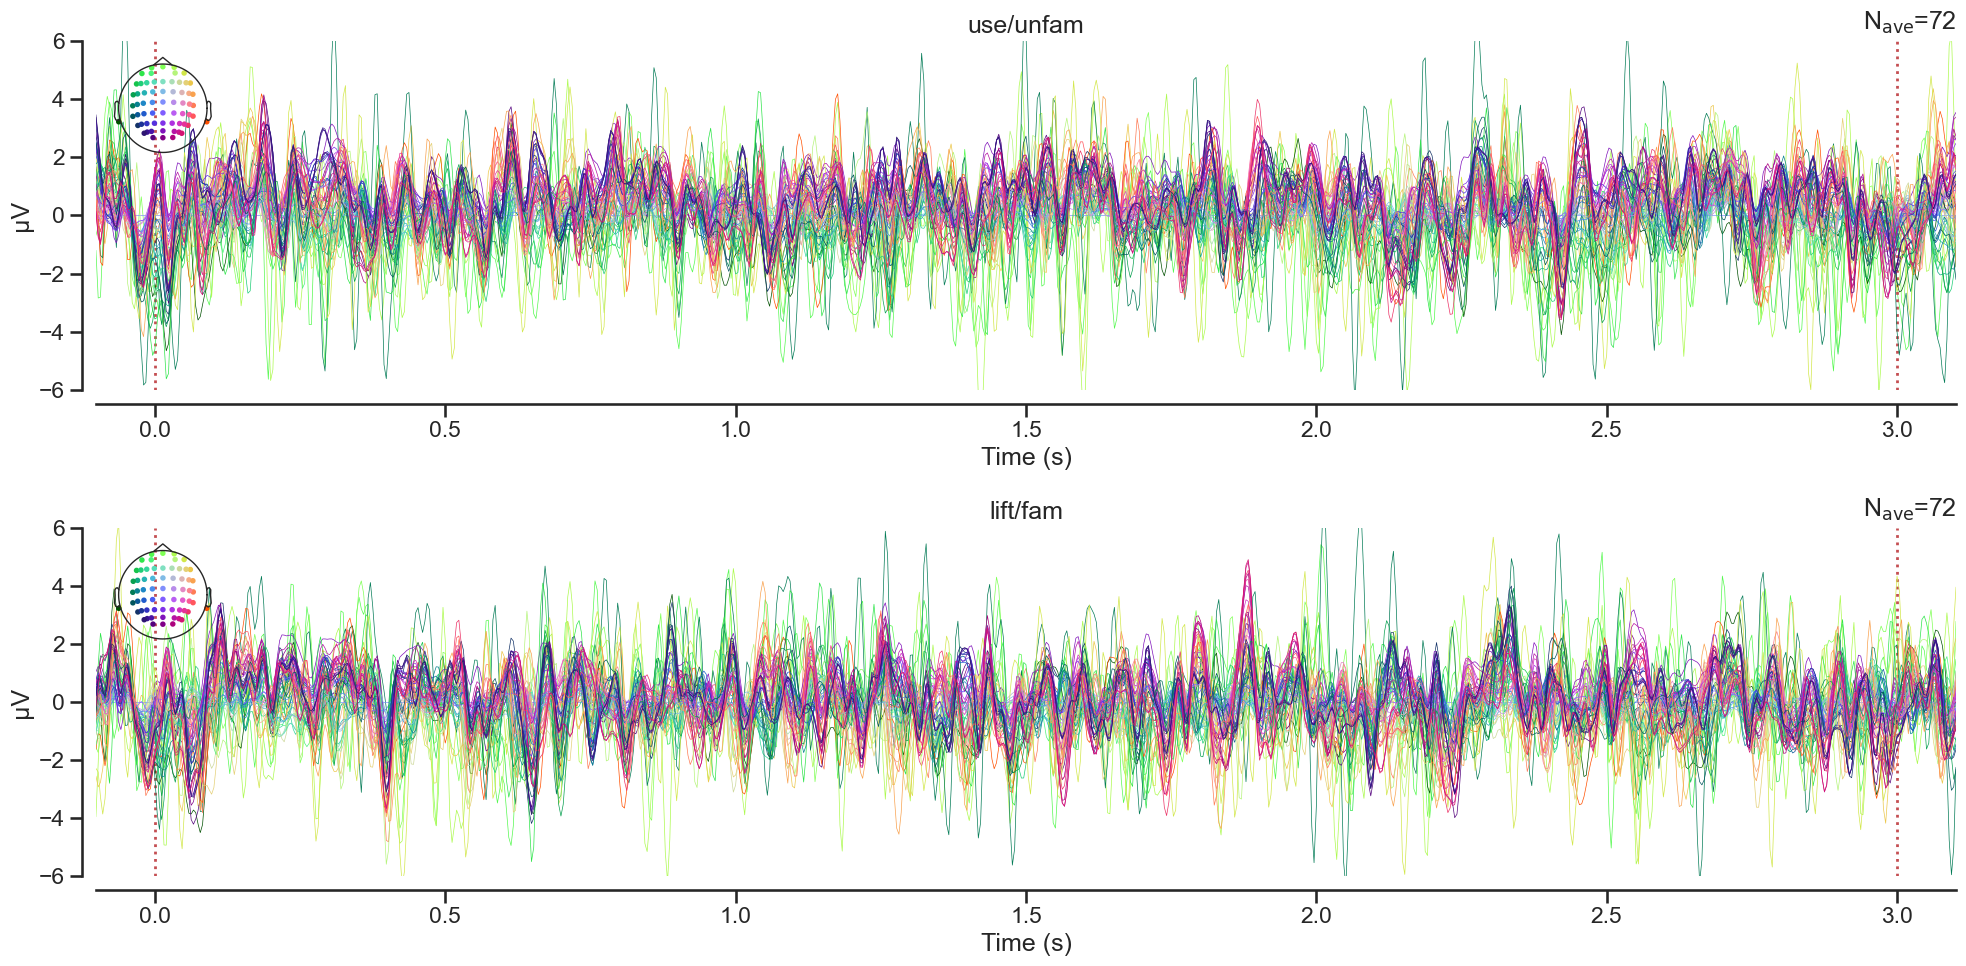

In [82]:
## numpy_epochs_lift has shape epochs x channels x times
## numpy_epochs_use has shape epochs x channels x times
info = clean_epochs.info
# lift_epochs = mne.EpochsArray(clean_epochs['lift'].get_data()  )
# use_epochs = mne.EpochsArray(clean_epochs['use'].get_data())


task_evoked_lift = clean_epochs['use/unfam'].average() 
task_evoked_use = clean_epochs['lift/fam'].average()

sns.set(context='talk', style='ticks')
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharey=True)

plt.subplots_adjust(hspace=0.5)


ax[0].axvline(0, ls=':', lw=2, color='r')
ax[0].axvline(3., ls=':', lw=2, color='r')



ax[1].axvline(0, ls=':', lw=2, color='r')
ax[1].axvline(3, ls=':', lw=2, color='r')


task_evoked_lift.plot( axes=ax[0], spatial_colors=True, scalings=1, show=False)
task_evoked_use.plot( axes=ax[1], spatial_colors=True, scalings=1, show=False)

ax[0].set(
    title='use/unfam',
    ylim=(-6,6)
)
ax[1].set(
    title='lift/fam',
    ylim=(-6,6)
)

sns.despine(offset=10)
fig.tight_layout()